<div style="border: 1px solid #CCCCFF; border-radius: 1px;">
<div style="margin: 5px">
<b class="alert-heading">Комментарий ревьюера</b>
<p>Σεμιόν, привет! :)</p>
<p>Меня зовут Алексей Секоцкий. Поздравляю с подготовкой очередного проекта. Предлагаю обращаться друг к другу на «ты» если нет возражений. Ниже стандартный блок с условными обозначениями:</p>
<div class="alert alert-success" role="alert">
всё отлично
</div>
<div class="alert alert-warning" role="alert">
рекомендации на будущее (не требующие доработки проекта)
</div>
<div class="alert alert-danger" role="alert">
критичные моменты требующие внимания (доработки)
</div>
<div class="alert alert-info">
информационные комментарии и итоговый
</div>

<hr>
<p>Пожалуйста, не изменяй и не удаляй мои комментарии – они потребуются для повторной проверки (при необходимости). Задавай вопросы и описывай сделанные изменения, помечая их любым удобным наглядным способом.</p>

<div class="alert alert-info">
    <b>Комментарий студента:</b> Отлично, а меня зовут Семён.
</div>

<div class="alert alert-success">
<b>Комментарий ревьюера 2</b>

Привет! Почему-то в нашей системе ты по-гречески записан. Я подумал, что так и надо :)
</div>

# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
# < Перенесите сюда исследовательский анализ данных >

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

In [2]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
import os
import glob
from tqdm import tqdm
import requests
import zipfile
import json

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [4]:
labels.head(3)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80


In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [6]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


<div class="alert alert-success">
<b>Комментарий ревьюера</b>

Отлично. Данные загружены и изучены.
</div>

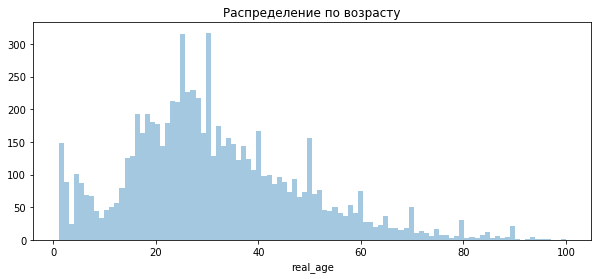

In [21]:
plt.figure(figsize=(10,4))
sns.distplot(labels.real_age, kde=False, bins=100)
plt.title("Распределение по возрасту")
plt.show()

<div class="alert alert-success">
<b>Комментарий ревьюера</b>

Отлично, что 100 корзин и отмечены пики на круглые даты. Откуда они могли появиться?
</div>

<div class="alert alert-info">
    <b>Комментарий студента:</b> Очень интересный вопрос, от числа корзин это не зависит. Я читал, что это может быть связано с особенностями алгоритмов (при прохождении темы про Adam), но не уверен.
</div>

<div class="alert alert-success">
<b>Комментарий ревьюера 2</b>

Это результат разметки. Когда точный возраст был неизвестен, то проводилось голование и возраст определялся «на глаз», а людям свойственно округлять :)
</div>

Большинство данных относятся к людям в возрасте 20-25 лет. И есть несколько пиков в 20, 40, 50, 60 и 80 лет. А также 0 - 5 лет. Эти пики для наших целей мы можем посчитать несущественными.

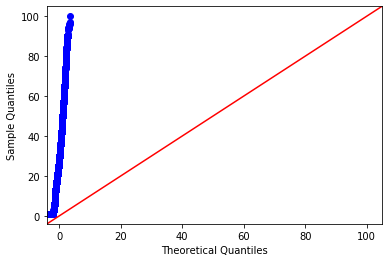

In [8]:
fig = sm.qqplot(labels.real_age, line='45')
plt.show()

Проверка на нормальность распределения показала, что нет нормального распределения.

<div class="alert alert-success">
<b>Комментарий ревьюера</b>

Для распределения возраста нормальное распределение скорее странность, а не норма.
</div>

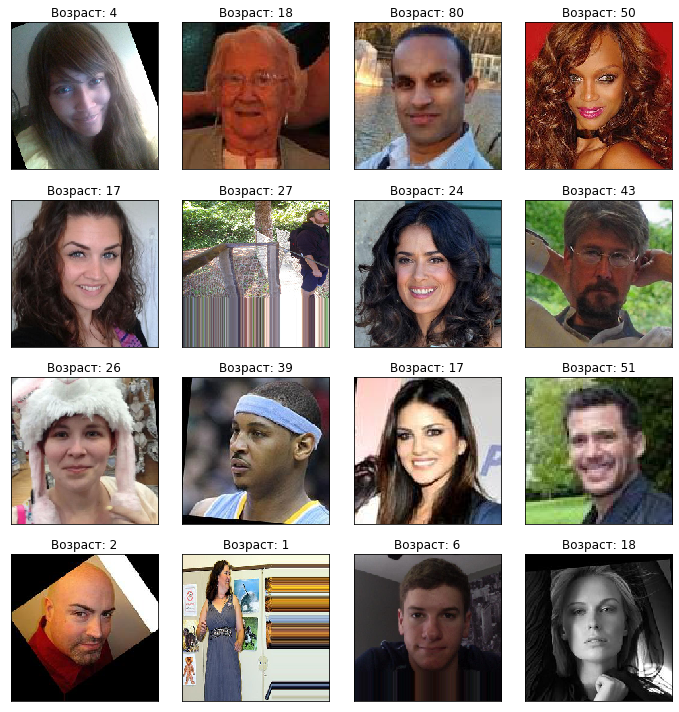

In [16]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title('Возраст: ' + str(labels.real_age[i]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

<div class="alert alert-warning">
<b>Комментарий от ревьюера</b>

Можно добавить вывод возраста над каждым фото для визуальной оценки используя `plt.title()`.
</div>

<div class="alert alert-info">
    <b>Комментарий студента:</b> Добавил.
</div>

<div class="alert alert-success">
<b>Комментарий ревьюера 2</b>

Супер!
</div>

Представлены фотографии людей, они более-менее приведены к одному размеру, но имеют искажения в виде поворотов, разной освещённости и пр. Поскольку распределение искажено, модель будет плохо предсказывать возраст пожилых людей и в основном даёт предсказание возраста ~ 30 лет.

<div class="alert alert-danger">
<b>Комментарий от ревьюера</b>

По результатам анализа датасета и фото важно добавить:

1. Пояснения по размеру выборки (большая, маленькая, достаточная) и предложения по работе с датасетом такого размера.
2. Другие важные особенности увиденные на фото: цветность, размер лиц в кадре и т.п. и предложить аугментацию (при необходимости).
<br/>
</div>

<div class="alert alert-info">
    <b>Комментарий студента:</b> Датасет мал. Фотографии цветные, как я понимаю, с ними выполнена предварительная обработка по определению размера лица, есть чёрно-белые фото, невалидные фото исключены. Возможно, следует использовать horizontal_flip аугментацию.
</div>

<div class="alert alert-success">
<b>Комментарий ревьюера 2</b>

Отличное дополнение. Верно, что отметил ч/б фото и предложил аугментацию.
</div>

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

# < скопируйте код сюда >
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd


def load_train(path):

    df = pd.read_csv('/datasets/faces/labels.csv')

    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        validation_split=0.2)

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):

    df = pd.read_csv('/datasets/faces/labels.csv')

    valid_datagen = ImageDataGenerator(
        rescale=1. / 255, 
        validation_split=0.2)

    validation_gen_flow = valid_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return validation_gen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
Train for 190 steps, validate for 48 steps

Epoch 1/5
190/190 - 118s - loss: 229.8644 - mae: 10.7853 - val_loss: 526.7424 - val_mae: 17.7643

Epoch 2/5
190/190 - 42s - loss: 64.4410 - mae: 6.0256 - val_loss: 518.7051 - val_mae: 17.5248

Epoch 3/5
190/190 - 42s - loss: 30.2035 - mae: 4.2375 - val_loss: 256.1237 - val_mae: 11.8437

Epoch 4/5
190/190 - 41s - loss: 19.9389 - mae: 3.4664 - val_loss: 101.8856 - val_mae: 7.6988

Epoch 5/5
190/190 - 41s - loss: 16.7548 - mae: 3.1778 - val_loss: 70.8945 - val_mae: 6.4589

Test MAE: 6.4589
```

<div class="alert alert-warning">
<b>Комментарий ревьюера</b>

Можно добавить аугментацию, подробнее про базовые возможности в <a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator">документации</a> или в <a href="https://towardsdatascience.com/machinex-image-data-augmentation-using-keras-b459ef87cd22">статье</a>. Почти всегда можно использовать простейшую – horizontal_flip, которая позволяет увеличить выборку в 2 раза.
</div>

<div class="alert alert-success">
<b>Комментарий ревьюера</b>

Отличный результат для 5 эпох. Что можно сказать о разнице значений метрики на тестовых и тренировочных данных? На что это может указывать?
</div>

```

# < скопируйте результат вывода на экран сюда >
# < длинные строки со скачиванием модели можно удалить >

```

## Анализ обученной модели

Достаточно низкий MAE достигнут уже на 4 эпохе (архитектура ResNet). Возможно, из-за того, что сам датасет достаточно мал и мала валидационная выборка.

<div class="alert alert-danger">
<b>Комментарий ревьюера</b>

В выводе желательно указать какая метрика достигнута, кратко описать параметры и особенности обучения модели, а также написать про склонность модели к переобучению (при необходимости).
<br/>

<div class="alert alert-info">
<b>Итоговый комментарий ревьюера</b>

Отличный проект. Осталось немного дополнить вывод по 1 разделу и итоговый. Буду ждать новую версию.
<hr>
</div>

<div class="alert alert-info">
    <b>Комментарий студента:</b> Достигнуто значение MAE 6.4589. Модель не склонна к переобучению, поскольку потери и MAE уменьшаются и там и там. Возможно, стоит рассмотреть добавление нескольких эпох. Достаточно низкий MAE достигнут уже на 4 эпохе (архитектура ResNet50). Возможно, из-за того, что сам датасет достаточно мал и мала валидационная выборка.
</div>

<div class="alert alert-success">
<b>Комментарий ревьюера 2</b>

Верно. На нашем датасете сложно достигнуть метрики ниже 6, а ниже 5 невозможно. Склонность к переобучению можно заметить по большой разнице значений между тестовой и тренировочной выборками.
</div>

<div class="alert alert-info">
<b>Итоговый комментарий ревьюера 2</b>

Спасибо за ответственный подход и отличные доработки. Поздравляю с успешной подготовкой проекта. Данная тема достаточно обширная для одного спринта, поэтому мы могли успеть только основы с которыми тебе удалось отлично справиться и подготовиться к дальнейшему погружению в материал. На будущее рекомендую ознакомиться с фреймворком <a href="https://pytorch.org/">PyTorch</a>. Желаю успехов в финальном спринте и профессии!
</div>

## Чек-лист

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [ ]  MAE модели не больше 8
- [ ]  Код обучения модели скопирован в финальную тетрадь
- [ ]  Результат вывода модели на экран перенесён в финальную тетрадь
- [ ]  По итогам обучения модели сделаны выводы